In [8]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
import os
import io
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
from sklearn.model_selection import train_test_split
from PIL import Image
from datetime import datetime


# Custom modules and packages
import params.siamese
import traversalcost.utils
from dataset import SiameseNetworkDataset
from model import SiameseNetwork
from loss import SiameseLoss
from train import train
from validate import validate
from test import test
from result import parameters_table, generate_log

## Load learning parameters

In [9]:
LEARNING_PARAMS = params.siamese.LEARNING

## Prepare data

In [10]:
# Create a Dataset for training
train_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for validation
# (same as training here since no transformation is applied to the data,
# train and validation sets will be split later)
val_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for testing
test_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_test.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Set the train dataset size
train_size = params.siamese.TRAIN_SIZE/(1-params.siamese.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [11]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [12]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (67736 samples)
15.0 % of the data for validation (14516 samples)
15.0 % of the data for testing (14516 samples)


## GPU?

In [13]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [14]:
# Create a model
nb_input_features = len(train_set[0][0])
model = SiameseNetwork(input_size=nb_input_features).to(device=device)

In [15]:
# Create a loss function
criterion = SiameseLoss(margin=LEARNING_PARAMS["margin"]).to(device=device)

In [16]:
# Define the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

# Create tensors to store the loss values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Create tensors to store the accuracy values
accuracy_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss, train_accuracy = train(model,
                                       device,
                                       train_loader,
                                       optimizer,
                                       criterion,
                                       epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model,
                                      device,
                                      val_loader,
                                      criterion,
                                      epoch) 
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy

  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.08727270025299111
Validation loss:  0.08259280830096569
Train accuracy:  74.44195110428723
Validation accuracy:  75.5648939101681


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.07536640777705524
Validation loss:  0.07411551436138573
Train accuracy:  78.1844218731546
Validation accuracy:  77.89335905208047


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.06960592668317082
Validation loss:  0.06634590182338518
Train accuracy:  79.97224518719736
Validation accuracy:  80.73160650316892


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0641010796406761
Validation loss:  0.060739483421725846
Train accuracy:  81.84717137120586
Validation accuracy:  82.70873518875723


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.05914360699899023
Validation loss:  0.060687821579990406
Train accuracy:  83.29396480453525
Validation accuracy:  82.4813998346652


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.05406089728070217
Validation loss:  0.049265930141909005
Train accuracy:  84.77323727412306
Validation accuracy:  86.35987875447782


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.04947135502664237
Validation loss:  0.04856699008478205
Train accuracy:  86.30270461792843
Validation accuracy:  86.14632130063379


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.045164387229024466
Validation loss:  0.04045185269500716
Train accuracy:  87.62105822605409
Validation accuracy:  88.99145770184624


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.040362912725316
Validation loss:  0.0386124008831605
Train accuracy:  89.05899374040392
Validation accuracy:  89.66657481399835


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.037414786231733076
Validation loss:  0.0362385355986425
Train accuracy:  89.98021731427896
Validation accuracy:  90.36924772664646


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.03417537121209505
Validation loss:  0.028579335992064508
Train accuracy:  90.79957481988897
Validation accuracy:  92.37393221273078


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.03074258600948229
Validation loss:  0.032044464644323624
Train accuracy:  91.83890398015826
Validation accuracy:  91.45770184623863


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.028365871548473243
Validation loss:  0.026603716228666023
Train accuracy:  92.56230069682296
Validation accuracy:  92.98015982364288


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0260792811303571
Validation loss:  0.022712347038205107
Train accuracy:  93.12330223219558
Validation accuracy:  94.17194819509507


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.024379386236790895
Validation loss:  0.02284659597292411
Train accuracy:  93.49681114916736
Validation accuracy:  94.25461559658308


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.021700084877813393
Validation loss:  0.018440986062412353
Train accuracy:  94.36636352899492
Validation accuracy:  95.46707081840728


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.020144378534686154
Validation loss:  0.017383879789106122
Train accuracy:  94.66310381481044
Validation accuracy:  95.5910719206393


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.01879327173007967
Validation loss:  0.02286945054274758
Train accuracy:  95.11633400259832
Validation accuracy:  93.83438963901901


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.01766501903622209
Validation loss:  0.01781245717155185
Train accuracy:  95.3791189323255
Validation accuracy:  95.28106916505925


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.01725376536761876
Validation loss:  0.014163344536419745
Train accuracy:  95.4529349238219
Validation accuracy:  96.33507853403141


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.015227432988014168
Validation loss:  0.01659121724370752
Train accuracy:  96.05379709460257
Validation accuracy:  95.76329567373932


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.01452828910739563
Validation loss:  0.012680780948734625
Train accuracy:  96.2767213889217
Validation accuracy:  96.76219344171948


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.014333324602297644
Validation loss:  0.015519809738901087
Train accuracy:  96.3032951458604
Validation accuracy:  95.99063102783136


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.012603963391522933
Validation loss:  0.011200886554113438
Train accuracy:  96.74028581551907
Validation accuracy:  97.28575365114357


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.011842467433863564
Validation loss:  0.016376982276873574
Train accuracy:  97.00307074524625
Validation accuracy:  95.74951777349132


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010959210456019167
Validation loss:  0.008457534195699355
Train accuracy:  97.19499232313689
Validation accuracy:  97.89887021217966


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010890861391859363
Validation loss:  0.011169781645817379
Train accuracy:  97.2378055982048
Validation accuracy:  97.01019564618352


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010423388865066656
Validation loss:  0.010128665754432064
Train accuracy:  97.35295854493917
Validation accuracy:  97.31330945163957


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010485010021089156
Validation loss:  0.011582173138348148
Train accuracy:  97.36772174323845
Validation accuracy:  96.94130614494351


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.009120921797811198
Validation loss:  0.013064998513834329
Train accuracy:  97.71022794378175
Validation accuracy:  96.52796913750345


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008841058977627186
Validation loss:  0.010408974388031707
Train accuracy:  97.76337545765915
Validation accuracy:  97.42353265362358


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.00833090326447142
Validation loss:  0.007372711518459383
Train accuracy:  97.8770520845636
Validation accuracy:  98.1606503168917


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008926837304492707
Validation loss:  0.0060388105511173015
Train accuracy:  97.7397543403803
Validation accuracy:  98.56020942408377


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008269140384282224
Validation loss:  0.011745386467713222
Train accuracy:  97.9139600803118
Validation accuracy:  97.23753100027555


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007364145400507395
Validation loss:  0.006488082989935439
Train accuracy:  98.14278965395063
Validation accuracy:  98.26398456875172


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007170146091105074
Validation loss:  0.009734841436968239
Train accuracy:  98.22398724459667
Validation accuracy:  97.58197850647561


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007877550798013623
Validation loss:  0.004675341745436454
Train accuracy:  97.98482343214835
Validation accuracy:  98.87021217966382


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006711201822320114
Validation loss:  0.005130179251014924
Train accuracy:  98.3258533128617
Validation accuracy:  98.82198952879581


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006339727502317995
Validation loss:  0.007540958477358543
Train accuracy:  98.43067202078659
Validation accuracy:  98.03664921465969


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006294631254107351
Validation loss:  0.003856714197438588
Train accuracy:  98.40262194401795
Validation accuracy:  99.18021493524387


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005889049135377179
Validation loss:  0.007253062316433974
Train accuracy:  98.53253808905161
Validation accuracy:  98.22265086800772


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0063779409539492715
Validation loss:  0.007395889601846624
Train accuracy:  98.42329042163695
Validation accuracy:  98.05042711490769


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.00546762282758726
Validation loss:  0.006409110595515236
Train accuracy:  98.69788591000355
Validation accuracy:  98.40865252135575


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005671773692443475
Validation loss:  0.004055636969809359
Train accuracy:  98.58125664343923
Validation accuracy:  99.05621383301185


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005486202551430077
Validation loss:  0.006908452759870217
Train accuracy:  98.62997519782685
Validation accuracy:  98.29154036924773


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005732955622141152
Validation loss:  0.008434527760806457
Train accuracy:  98.58125664343923
Validation accuracy:  97.86442546155966


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005618831045165785
Validation loss:  0.005171946504128054
Train accuracy:  98.60783040037794
Validation accuracy:  98.65665472581979


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005056599722084667
Validation loss:  0.005893469424015691
Train accuracy:  98.71412542813275
Validation accuracy:  98.48443097271976


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005128770732699882
Validation loss:  0.004661704295638965
Train accuracy:  98.71560174796268
Validation accuracy:  98.83576742904381


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005251550742242981
Validation loss:  0.003538590763584764
Train accuracy:  98.70822014881304
Validation accuracy:  99.16643703499587


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004344260437472093
Validation loss:  0.005111074458709241
Train accuracy:  98.9281918034723
Validation accuracy:  98.8013226784238


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004594356094674332
Validation loss:  0.007278089569512311
Train accuracy:  98.84994685248613
Validation accuracy:  98.0642050151557


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004805608352864332
Validation loss:  0.0072549251708230785
Train accuracy:  98.80270461792843
Validation accuracy:  98.03664921465969


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003813822467471064
Validation loss:  0.0035762336773855308
Train accuracy:  99.10977914255345
Validation accuracy:  99.20777073573987


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004230182189617493
Validation loss:  0.004896252098111723
Train accuracy:  98.95181292075115
Validation accuracy:  98.7806558280518


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003968877871753868
Validation loss:  0.0029519576667028477
Train accuracy:  99.00791307428841
Validation accuracy:  99.30421603747588


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004506468281613327
Validation loss:  0.00405883590079483
Train accuracy:  98.87209164993504
Validation accuracy:  99.00110223201985


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004133740424620897
Validation loss:  0.0027547820567641623
Train accuracy:  99.01824731309792
Validation accuracy:  99.41443923945991


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0033790320624105764
Validation loss:  0.0026079711200677614
Train accuracy:  99.17768985473013
Validation accuracy:  99.27666023697988


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003942500107338594
Validation loss:  0.006501841713727702
Train accuracy:  99.04925002952639
Validation accuracy:  98.29154036924773


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0038855319400339953
Validation loss:  0.005045422136430764
Train accuracy:  99.0654895476556
Validation accuracy:  98.65665472581979


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0036125141538932877
Validation loss:  0.004852939544795368
Train accuracy:  99.139305539152
Validation accuracy:  98.8013226784238


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003625762374056776
Validation loss:  0.004233167155969904
Train accuracy:  99.13782921932207
Validation accuracy:  98.92532378065583


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003625081032883935
Validation loss:  0.00243722065454472
Train accuracy:  99.11420810204322
Validation accuracy:  99.4351060898319


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0038686985206263487
Validation loss:  0.004322707979213692
Train accuracy:  99.03153419156726
Validation accuracy:  98.90465693028382


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0031887205251438914
Validation loss:  0.0030809087403906336
Train accuracy:  99.2131215306484
Validation accuracy:  99.26288233673188


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0029107259232040786
Validation loss:  0.0035087846564170024
Train accuracy:  99.30465336010393
Validation accuracy:  99.09754753375586


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002888896993719344
Validation loss:  0.0023727568978287837
Train accuracy:  99.30317704027401
Validation accuracy:  99.41443923945991


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003672041024879057
Validation loss:  0.001800399585442396
Train accuracy:  99.10092122357388
Validation accuracy:  99.62799669330394


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0030438958256522137
Validation loss:  0.0036641745089598427
Train accuracy:  99.28103224282509
Validation accuracy:  99.09065858363185


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0035779813746020296
Validation loss:  0.00471293536683602
Train accuracy:  99.12158970119286
Validation accuracy:  98.84265637916782


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0034522379795133337
Validation loss:  0.00215926665570669
Train accuracy:  99.12601866068265
Validation accuracy:  99.51777349131993


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0027896757577673182
Validation loss:  0.0030598472516639116
Train accuracy:  99.33565607653242
Validation accuracy:  99.3455497382199


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0030806884415820594
Validation loss:  0.0020556531185981722
Train accuracy:  99.27807960316522
Validation accuracy:  99.58666299255994


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0032560372508787907
Validation loss:  0.006660989479526943
Train accuracy:  99.19835833234912
Validation accuracy:  98.40176357123174


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003214053163697153
Validation loss:  0.0027490337610056024
Train accuracy:  99.24855320656667
Validation accuracy:  99.3731055387159


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002708367803736438
Validation loss:  0.004112048874637892
Train accuracy:  99.36518247313099
Validation accuracy:  98.92532378065583


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002748363235362078
Validation loss:  0.0028329395580347547
Train accuracy:  99.35337191449156
Validation accuracy:  99.26288233673188


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0029547653197046155
Validation loss:  0.0021950983081324774
Train accuracy:  99.29284280146452
Validation accuracy:  99.53844034169192


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002096931359706916
Validation loss:  0.002340668670849522
Train accuracy:  99.53053029408291
Validation accuracy:  99.44199503995591


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002642724035761554
Validation loss:  0.0016954996491554664
Train accuracy:  99.38142199126018
Validation accuracy:  99.66933039404795


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0028573618788444513
Validation loss:  0.0028539870314080564
Train accuracy:  99.34156135585214
Validation accuracy:  99.30421603747588


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0023378349833605536
Validation loss:  0.001451079552123397
Train accuracy:  99.47000118105586
Validation accuracy:  99.71755304491596


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0026616608854594295
Validation loss:  0.008256596069996316
Train accuracy:  99.37551671194048
Validation accuracy:  97.96775971341968


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0029057377432248747
Validation loss:  0.0017218918709847502
Train accuracy:  99.32384551789299
Validation accuracy:  99.64177459355194


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0024340332409224495
Validation loss:  0.0027703100421552092
Train accuracy:  99.44047478445731
Validation accuracy:  99.3386607880959


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0020764486277625458
Validation loss:  0.0018050530020225514
Train accuracy:  99.53643557340263
Validation accuracy:  99.63488564342794


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0027432128408003856
Validation loss:  0.0011241743012868886
Train accuracy:  99.3341797567025
Validation accuracy:  99.79333149627996


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0023415735069701026
Validation loss:  0.0036800757731569496
Train accuracy:  99.44638006377701
Validation accuracy:  99.13888123449986


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002033224645949288
Validation loss:  0.003407466730989089
Train accuracy:  99.52757765442306
Validation accuracy:  99.20777073573987


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0025055080196469304
Validation loss:  0.0019711239977805396
Train accuracy:  99.43752214479746
Validation accuracy:  99.58666299255994


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0022784593045479347
Validation loss:  0.0020750879129550794
Train accuracy:  99.46704854139601
Validation accuracy:  99.54532929181593


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002097442691637391
Validation loss:  0.002266415433305837
Train accuracy:  99.5246250147632
Validation accuracy:  99.51777349131993


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0020372030796611557
Validation loss:  0.0028054069805611335
Train accuracy:  99.56300933034133
Validation accuracy:  99.30421603747588


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002694818172322426
Validation loss:  0.002617493588764565
Train accuracy:  99.3769930317704
Validation accuracy:  99.41443923945991


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002668325280519141
Validation loss:  0.001819519043001572
Train accuracy:  99.38437463092004
Validation accuracy:  99.57977404243593


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.001786089390146918
Validation loss:  0.0021219107974730926
Train accuracy:  99.60434628557931
Validation accuracy:  99.49021769082393


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002452376826707629
Validation loss:  0.0017508251555592217
Train accuracy:  99.4139010275186
Validation accuracy:  99.60044089280794


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0020031539966880825
Validation loss:  0.002834204931041874
Train accuracy:  99.57777252864061
Validation accuracy:  99.3455497382199


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002056018298103125
Validation loss:  0.003613236987971524
Train accuracy:  99.55267509153182
Validation accuracy:  99.04243593276385


### Visualization

Text(0.5, 0, 'Epoch')

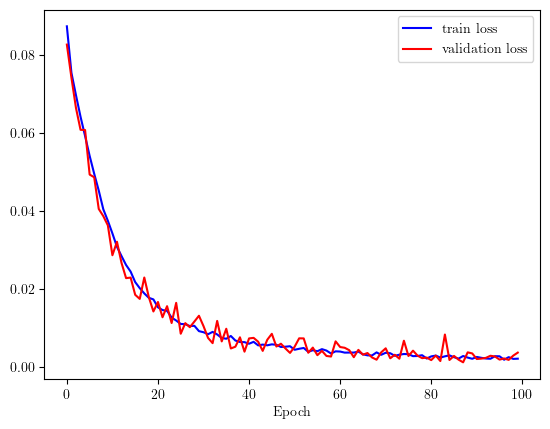

In [17]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

figure = plt.figure()

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

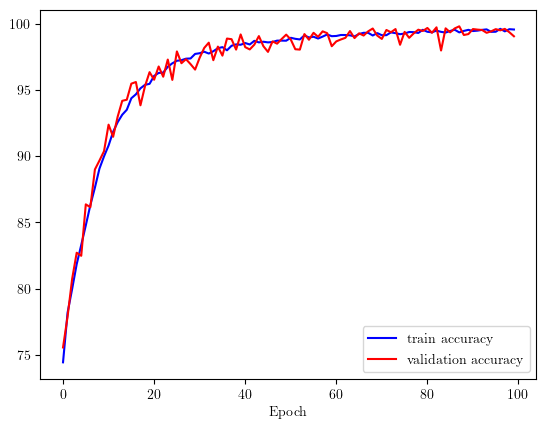

In [18]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

## Testing

In [19]:
# Test the model
test_loss, test_accuracy = test(model,
                                device,
                                test_loader,
                                criterion)

print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

Test loss:  0.0036214202101904455
Test accuracy:  99.04932488288784


## Compute and display traversal costs

In [20]:
# Compute the traversal costs from the features of the dataset
costs_df = traversalcost.utils.compute_traversal_costs(
    dataset=params.siamese.DATASET,
    cost_function=model.to(device="cpu"),
    to_tensor=True
)

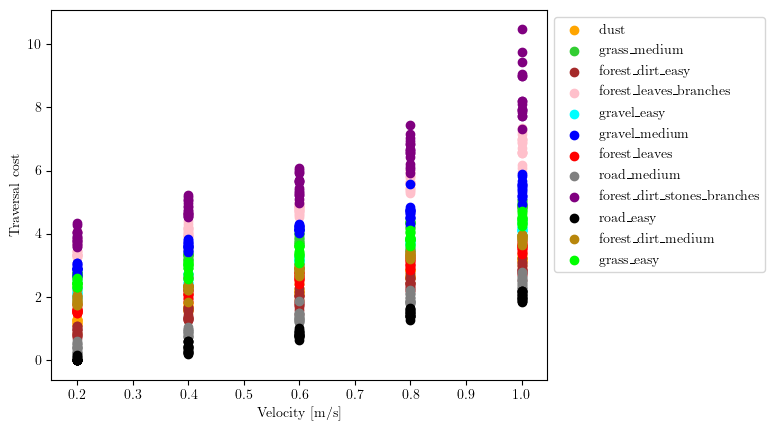

In [21]:
# Display the traversal costs
cost_graph = traversalcost.utils.display_traversal_costs(costs_df)

In [29]:
df_filtered = costs_df.loc[costs_df['linear_velocity'] == 1.0]
df_filtered.groupby(['terrain_class']).mean()

,linear_velocity,cost
terrain_class,,
dust,1.0,3.226723
forest_dirt_easy,1.0,2.870805
forest_dirt_medium,1.0,3.861141
forest_dirt_stones_branches,1.0,8.476813
forest_leaves,1.0,3.575056
forest_leaves_branches,1.0,6.732884
grass_easy,1.0,4.455072
grass_medium,1.0,4.877555
gravel_easy,1.0,4.132645


## Generate a log directory

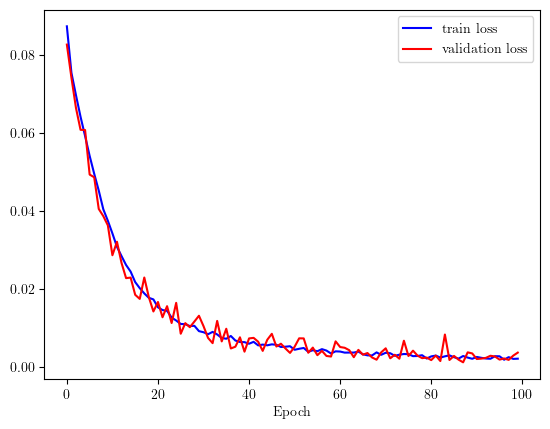

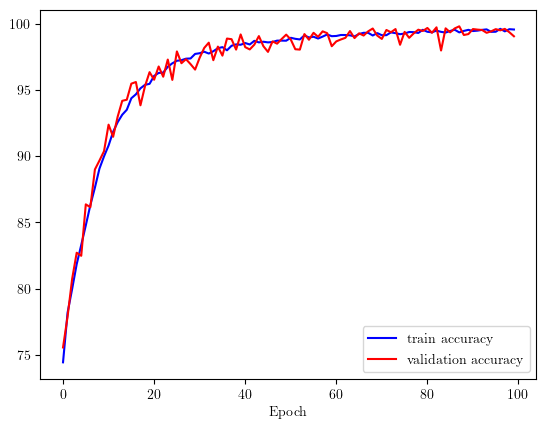

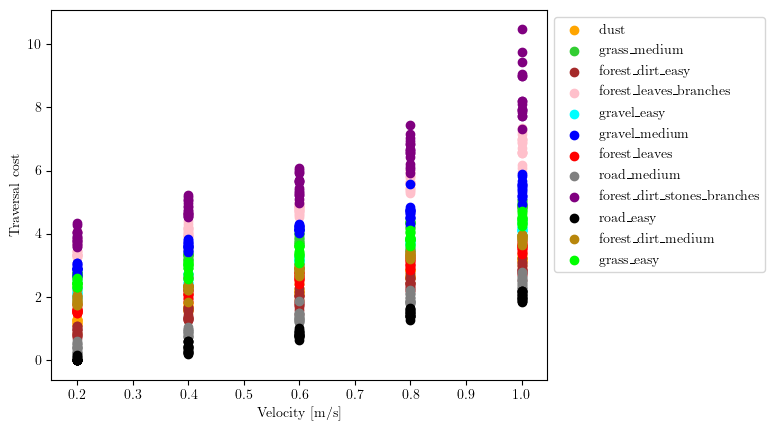

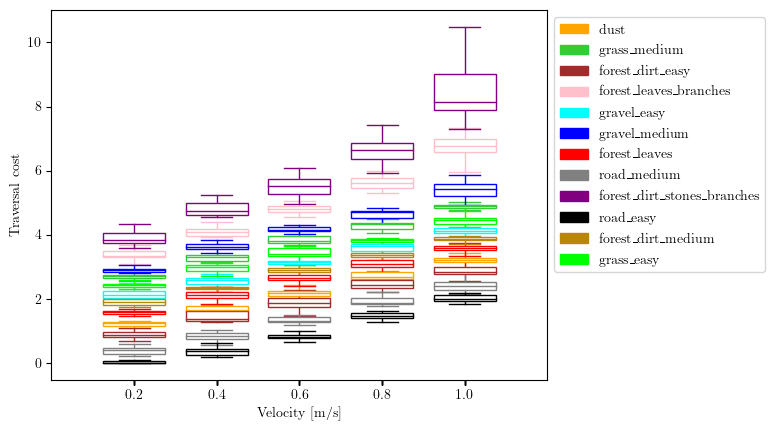

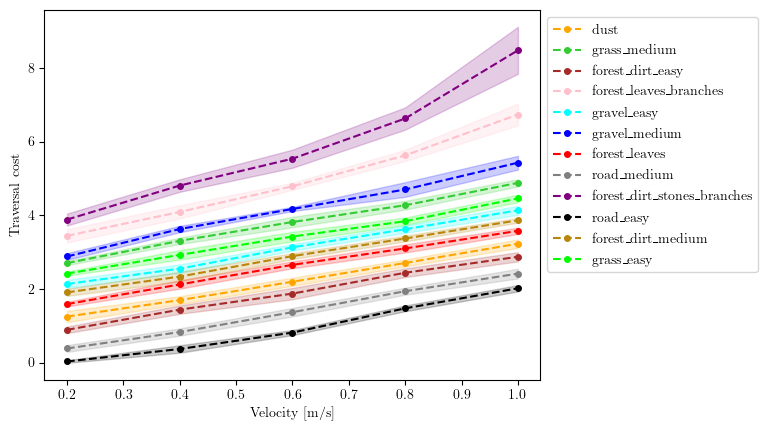

In [23]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.siamese.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.siamese.LOG_DIR:
    results_directory = "logs/_" +\
                        params.siamese.LOG_DIR
else:
    results_directory = "logs/_" +\
                        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
generate_log(dataset_directory=params.siamese.DATASET,
             results_directory=results_directory,
             test_loss=test_loss,
             test_accuracy=test_accuracy,
             parameters_table=params_table,
             model=model,
             loss_values=loss_values,
             accuracy_values=accuracy_values)